# Ex_3dvar

This is an example of data assimilation on the ice thickness with known kinematics.
The example focuses on mean estimation with the 3dvar method.

### Import necessary packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from WENO import *
from transport_onestep import *

### Import synthetic ground truth

For simulation purpose, we assume that the ground truth is known. 

The ground truth contains information on velocity and ice thickness. They are obtained by numerically solving the viscous-plastic (VP) sea ice model.

The VP sea ice model is solved using WENO spatial discretization scheme and TVD RK3 time integration technique with spatial resolution $dx=10$ km and time step $dt=1$ s. The simulation domain is $[0,2000]$ km, and the total simulation time is 1 hour. The initial conditions are

\begin{equation*}
\begin{gathered}
u(x,0)=0 \text{ m/s} \quad \text{on} \quad  [0, 2000] \text{ km},\\
h(x,0)= \begin{cases}
0.01 \text{ m} \quad \text{on} \quad [400, 1600] \text{ km},\\
2 \text{ m} \quad \text{on} \quad [0,400] \cup [1600, 2000] \text{ km},
\end{cases}\\
A(x,0)= \begin{cases}
0 \quad \text{on} \quad [400, 1600] \text{ km},\\
0.8 \quad \text{on} \quad [0,400] \cup [1600, 2000] \text{ km}.
\end{cases}
\end{gathered}
\end{equation*}

Uniform constant wind forcing $u_a=10$ m/s is imposed. For simplicity, periodic boundary conditions are used when solving the model.

The imported velocity and ice thickness are point values defined at the center of grid cells at every second during the simulation period, and are denoted by $u_{true}$ and $h_{true}$ respectively.

In [4]:
# import true solution from matlab
import scipy.io
mat = scipy.io.loadmat('true.mat')

u_true = mat['u_true']
h_true = mat['h_true']

[Nx,Nt]=np.shape(u_true)

# spatial resolution
dx=1e4
# time step
dt=1

### Function creating observation data

We assume that we are able to obtain noisy observations of ice thickness, with observation operator $H$. That is, at each discrete time instance, the observation data is constructed by

$$ y_{j+1}=H(h_{j+1})+\eta_{j+1}$$

where $\{\eta_j\}$ is an i.i.d. sequence with $\eta_1\sim N(0,\Gamma)$ and $\Gamma=\gamma^2 I$.

In [13]:
# create observation data
def _obs(H,h_true,gamma):
    """
    Given signal vector, create observation data with additive noise.

    Parameters
    ----------
    H: 
       observation operator
    h_true: numpy.ndarray
       the underlying signal vector
    gamma: float
       standard deviation of the observation noise
       
    Returns
    -------
    numpy.ndarray
       observation data of same size as signal h_true
    """
    np.random.seed(seed=10)
    [Nx,]=np.shape(h_true)
    myy = H@h_true + np.random.normal(0,gamma,[Nx,])
    # cut-off negative values for ice thickness
    myy[myy<0]=0 
    return myy

### 3DVAR method

3DVAR method is a variational method which focus on generating a single point (mean estimation for example). In the linear case (linear observations $H(h)=H h$), it can be written as the following update formulae:

\begin{gather*}
\hat{m}_{j+1}=\mathbb{\Psi}(m_j),\\
m_{j+1}=(I-KH)\hat{m}_{j+1}+Ky_{j+1},
\end{gather*}

where $K=\hat{C}H^TS^{-1}$ and $S=H\hat{C}H^T+\Gamma$.

In [14]:
# data assimilation -- 3dvar
def _3dvar(mhat,y,K,H):
    d = y-H.dot(mhat)
    m = mhat + K.dot(d)
    return m

### Problem set up

We construct the initial mean by adding noise on the true signal

$$ m_{0}=h_{0}+\eta_{0}$$

with $\eta_0\sim N(0,std_{init}^2 I)$.

In [15]:
# create initial values for mean
std_init=0.05 # noise standard deviation 
mymean = np.zeros([Nx,Nt]) # initialization
np.random.seed(seed=1)
h0=h_true[:,0]
mymean[:,0]=h0+np.random.normal(0,std_init,[Nx,])

# initialize observation data and prior mean
myy = np.zeros([Nx,Nt])
myprmean = np.zeros([Nx,Nt])
myprmean[:,0]=mymean[:,0]

In [16]:
# data assimilation parameter
gamma=0.05 # observation noise standard deviation
eta=10 # covariance parameter in 3dvar

myI=np.eye(Nx) 
H=myI # observation operator
Gamma=gamma**2*myI
C=gamma**2/eta*myI # model covariance
deno=(H@C@(H.T)+Gamma)
K=(C@(H.T))@np.linalg.inv(deno) # Kalman gain

In [17]:
# perform 3dvar
from transport_onestep import _transport
for j in range(Nt-1):
    mhat = np.zeros([Nx,1])
    mhat = _transport(u_true[:,j+1],mymean[:,j],dx,dt)
    myy[:,j+1] = _obs(H,h_true[:,j+1],gamma)
    mymean[:,j+1] = _3dvar(mhat,myy[:,j+1],K,H)
    myprmean[:,j+1] = _transport(u_true[:,j+1],myprmean[:,j],dx,dt)
    j = j+1

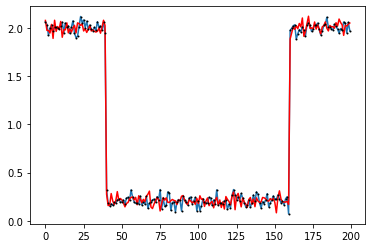

In [18]:
# plot the solution
plt.plot(mymean[:,Nt-1]) # posterior mean
plt.plot(myprmean[:,Nt-1],'r') # prior mean
plt.plot(myy[:,Nt-1],'k.',markersize=2) # observation data